In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from pyDOE import lhs
import HelmholtzEquation_torch

/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cropExact = False

In [3]:
pData = '/bigdata/hplsim/production/AIPP/Data/LaserEvolution/runs/004_LaserOnly/simOutput/h5/'
dataForFrame = np.sort(os.listdir(pData))

# Load data for t0
Exact = HelmholtzEquation_torch.loadFrame(pData + dataForFrame[0], 'fields/E/x')
if(cropExact):
    Exact = Exact[100:156,:,50:200]

# Domain bounds
Es0m = int(Exact.shape[0] / 2)
Es2m = int(Exact.shape[2] / 2)
Est = len(dataForFrame)
lb = np.array([-1 * Es0m, 0, -1 * Es2m, 0])  # lower bound consists of [lower bound of x, lower bound of t]
ub = np.array([Es0m, 2000, Es2m, Est ])  # ub follows from lb


# define size of training data
p_N0y = 0.01
p_N0x = 0.1
p_N0z = 0.1
N0 = int(0.001 * np.prod(Exact.shape)) # one percent of overall size
N_b = int(0.5 * len(dataForFrame))
N_f = int(0.0001 * np.prod(Exact.shape)*Est)
N_f = 1

# defines the neural network
layers = [2, 100, 100, 100, 100, 2]

t = np.array(range(len(dataForFrame)))  # get timestamps
x = np.array(range(Exact.shape[0]))
y = np.array(range(Exact.shape[1]))
z = np.array(range(Exact.shape[2]))

/data/2000/fields/E/x


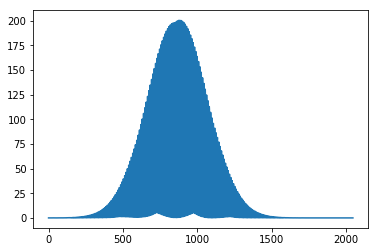

In [4]:
plt.plot(np.sum((Exact[Es0m,...]**2),axis=-1))

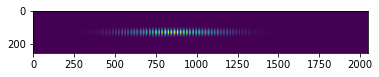

In [5]:
plt.imshow((Exact[Es0m,...]**2).T)

In [6]:
###########################
idx_x = np.random.choice(len(x), int(p_N0x * len(x)), replace=False)
idx_y = np.random.choice(len(y), int(p_N0y * len(y)), replace=False)
idx_z = np.random.choice(len(z), int(p_N0z * len(z)), replace=False)

In [7]:
p_N0y = 0.5
p_N0z = 0.5
idx_x = [128]
idx_y = np.random.choice(len(y), int(p_N0y * len(y)), replace=False)
idx_z = np.random.choice(len(z), int(p_N0z * len(z)), replace=False)

Train at 128

In [8]:
x0,y0,z0 = np.meshgrid(x[idx_x],y[idx_y],z[idx_z])
x0 = x0.reshape((-1))
y0 = y0.reshape((-1))
z0 = z0.reshape((-1))

In [9]:
Ex0 = Exact[x0,y0,z0]

idx_t = np.random.choice(len(t), N_b, replace=False)
idx_t = np.sort(idx_t)
tb = t[idx_t]

X_f = lb + (ub - lb) * lhs(4, N_f)

In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
import importlib
importlib.reload(HelmholtzEquation_torch)

model = HelmholtzEquation_torch.HelmholtzNet(x0, y0, z0, Ex0, tb, X_f, layers, lb, ub).cuda()

In [12]:
import torch.optim as optim
lbfgs_optimizer = optim.LBFGS(model.parameters(),lr=0.05, max_iter=50000, max_eval=50000)
adam_optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [13]:
batch_size = 2**16

def closure_adam():
    adam_optimizer.zero_grad()
    loss = model.loss()#batch_size=batch_size)
    loss.backward()
    print("Epoch %d Loss %.10f:"%(epoch + 1, loss))
    return loss

def closure_lbfgs():
    lbfgs_optimizer.zero_grad()
    loss = model.loss()#batch_size=batch_size)
    print("Epoch %d Loss %.10f:"%(epoch + 1, loss))
    loss.backward()
    return loss

epochs_adam = 0
epochs_lbfgs = 1000

In [14]:
for epoch in range(epochs_adam):
    adam_optimizer.step(closure_adam)

In [ ]:
for epoch in range(epochs_lbfgs):
    lbfgs_optimizer.step(closure_lbfgs)

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0960497335:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0954003185:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

Epoch 1 Loss 0.0774424821:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0773803443:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0773301050:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],


tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771196112:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771192163:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771172866:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771172643:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771150142:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771147311:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771121234:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771121085:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771115422:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771114752:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 1 Loss 0.0771104991:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 2 Loss 0.0771104991:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720, 

Epoch 10 Loss 0.0771104395:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 10 Loss 0.0771104321:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 10 Loss 0.0771104321:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 16 Loss 0.0771103501:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771103352:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771103203:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 16 Loss 0.0771090537:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771089867:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771089271:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 16 Loss 0.0771084204:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771083981:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771083906:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 16 Loss 0.0771075040:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771074146:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771073103:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 16 Loss 0.0771053731:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771053433:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 16 Loss 0.0771053061:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 20 Loss 0.0771051198:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 21 Loss 0.0771051198:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 21 Loss 0.0771051198:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 26 Loss 0.0771049932:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 26 Loss 0.0771049783:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 26 Loss 0.0771049559:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 26 Loss 0.0771037787:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 26 Loss 0.0771037340:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 26 Loss 0.0771037042:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 30 Loss 0.0771035030:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 30 Loss 0.0771034956:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 30 Loss 0.0771034881:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 30 Loss 0.0771029741:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 30 Loss 0.0771029443:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 30 Loss 0.0771029219:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 30 Loss 0.0771025866:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 31 Loss 0.0771025866:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 31 Loss 0.0771025717:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 38 Loss 0.0771025196:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 38 Loss 0.0771025196:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 39 Loss 0.0771025196:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

Epoch 46 Loss 0.0771024823:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 46 Loss 0.0771024823:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0771024823:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0771006942:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0771005303:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0770991147:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0770990849:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0770986825:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 47 Loss 0.0770986527:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

Epoch 50 Loss 0.0770984739:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 50 Loss 0.0770984665:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 50 Loss 0.0770984739:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770975202:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770973787:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770931244:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770927817:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770852193:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770849735:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770774186:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770771056:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770741701:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770740137:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770646632:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770641118:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770554915:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770551562:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770339668:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770329982:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770252794:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0770247877:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769975856:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769963413:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769776404:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769767314:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769409239:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769397169:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769063085:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0769044906:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768764541:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768751204:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768500119:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768488199:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768131614:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0768112093:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0767760947:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0767752528:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0767434537:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0767416134:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0767018944:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766999945:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766809285:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766803920:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766595155:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766583681:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766222626:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766208246:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766087919:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0766086057:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765872151:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765851215:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765634179:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765630305:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765424147:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765413195:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765223503:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765217245:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765080303:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0765071437:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764854327:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764846280:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764731988:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764729232:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764613450:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764603913:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764416158:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764413401:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764202923:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764190853:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764056668:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0764049143:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763832033:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763828531:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763710737:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763705075:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763609931:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763606280:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763523877:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763521343:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763338953:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763330460:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763201341:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0763191730:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762963295:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762954503:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762789696:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762782693:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762696564:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762691125:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762469172:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762459189:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762291253:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762285143:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762177929:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762172788:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762044936:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0762040988:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761978179:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761971325:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761868805:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761866122:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761795491:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761791989:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761735514:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761733949:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761694759:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761692375:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761624947:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761621967:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761553794:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761551708:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761472881:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761468410:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761410892:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761409253:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761364400:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761360228:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761262476:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761257112:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761180297:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761178583:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761155337:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761154145:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761123896:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761123225:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761091337:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761089548:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761066601:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761065856:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761034191:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0761031508:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760971308:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760968029:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760897323:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760895014:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760853365:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760851353:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760807246:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760801435:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760727450:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760725588:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760682374:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760681480:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760657862:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760656521:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760603994:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760601833:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760545880:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760543048:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760499984:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760497451:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760444999:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760443583:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760409385:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720,  0.0625, -1.0000]], device='cuda:0',
       grad_fn=<SubBackward0>)
Epoch 53 Loss 0.0760407746:
tensor([[ 1.0000,  0.4000,  1.6797, -1.0000],
        [ 1.0000,  0.4000,  1.7344, -1.0000],
        [ 1.0000,  0.4000,  0.5078, -1.0000],
        ...,
        [ 1.0000,  0.5720,  0.2891, -1.0000],
        [ 1.0000,  0.5720,  0.2109, -1.0000],
        [ 1.0000,  0.5720

In [ ]:
X,Y,Z = np.meshgrid([128],y,z)

In [ ]:
XX = np.hstack( (X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1),np.zeros( (np.prod(X.shape),1)) ) )

In [ ]:
XX_torch = torch.from_numpy(XX).float().cuda()

In [ ]:
Ex = torch.squeeze(model.cuda().forward(XX_torch)).cpu().detach().numpy()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(Ex.reshape(2048, 256).T)

In [ ]:
np.max(Ex)

In [ ]:
plt.imshow(Exact[128,...].T)

In [ ]:
plt.imshow(Exact[128,...].T - Ex.reshape(2048, 256).T)

In [ ]:
np.mean( (Ex - Exact[128,...].reshape(-1)) ** 2)

In [ ]:
x0 = torch.cat([model.x_0_gpu, model.t_0_gpu], 1)

In [ ]:
Ex = torch.squeeze(model.cuda().forward(x0)).cpu().detach().numpy()

In [ ]:
np.mean( (Ex - model.Ex_0.reshape(-1)) ** 2)